In [2]:
import os
import numpy as np
import cv2
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.7' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [3]:
COLOR_MAP = {
    (0, 0, 0): 0,             # Background
    (0, 159, 255): 1,         # Normal
    (0, 255, 0): 2,           # Weak
    (255, 216, 0): 3,         # Moderate
    (255, 0, 0): 4            # Strong
}

def encode_mask(mask):
    mask_array = np.array(mask)
    label_mask = np.zeros(mask_array.shape[:2], dtype=np.uint8)
    for color, class_id in COLOR_MAP.items():
        label_mask[np.all(mask_array == color, axis=-1)] = class_id
    return label_mask


In [4]:
class ERIHCDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_paths = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir)])
        self.mask_paths = sorted([os.path.join(mask_dir, f) for f in os.listdir(mask_dir)])
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        mask = Image.open(self.mask_paths[idx]).convert("RGB")
        label = encode_mask(mask)

        if self.transform:
            augmented = self.transform(image=np.array(image), mask=label)
            image = augmented["image"]
            label = augmented["mask"]

        return image, label


In [5]:
def get_transforms():
    return A.Compose([
        A.Resize(256, 256),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.2),
        A.Normalize(mean=(0.485, 0.456, 0.406), 
                    std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ])


In [6]:
train_dataset = ERIHCDataset(
    image_dir="/kaggle/input/er-ihc-images/ER_IHC_Int_Image",
    mask_dir="/kaggle/input/er-ihc-mask/Mask_WO_BG",
    transform=get_transforms()
)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)


# Define Model A – UNet++ for Morphology-Aware Segmentation


In [7]:
!pip install -q segmentation-models-pytorch albumentations


In [8]:
import segmentation_models_pytorch as smp


In [9]:
# Define UNet++ with a ResNet encoder
def get_model_a(num_classes=5):
    model = smp.UnetPlusPlus(
        encoder_name="resnet34",        # or 'efficientnet-b0'
        encoder_weights="imagenet",     # use pretrained weights
        in_channels=3,                  # RGB
        classes=num_classes,            # 5-class segmentation
        activation=None                 # raw logits
    )
    return model


In [10]:
# Loss: Combination of Dice + CrossEntropy
def dice_loss(pred, target, smooth=1):
    pred = torch.softmax(pred, dim=1)
    target_one_hot = torch.nn.functional.one_hot(target, num_classes=5).permute(0, 3, 1, 2).float()
    intersection = (pred * target_one_hot).sum(dim=(2, 3))
    union = pred.sum(dim=(2, 3)) + target_one_hot.sum(dim=(2, 3))
    dice = (2. * intersection + smooth) / (union + smooth)
    return 1 - dice.mean()

def hybrid_loss(pred, target):
    ce = nn.CrossEntropyLoss()(pred, target)
    dice = dice_loss(pred, target)
    return ce + dice


In [12]:
def train_model(model, dataloader, epochs=10, lr=1e-3):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for images, masks in dataloader:
            images = images.to(device)
            masks = masks.to(device).long()  # <-- Fix applied here
            preds = model(images)
            loss = hybrid_loss(preds, masks)

            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(dataloader):.4f}")
    
    return model
model_a = get_model_a()
model_a = train_model(model_a, train_loader, epochs=10)


Epoch 1/10, Loss: 1.3692
Epoch 2/10, Loss: 0.9544
Epoch 3/10, Loss: 0.9139
Epoch 4/10, Loss: 0.8864
Epoch 5/10, Loss: 0.8733
Epoch 6/10, Loss: 0.8400
Epoch 7/10, Loss: 0.8261
Epoch 8/10, Loss: 0.7369
Epoch 9/10, Loss: 0.7049
Epoch 10/10, Loss: 0.7028


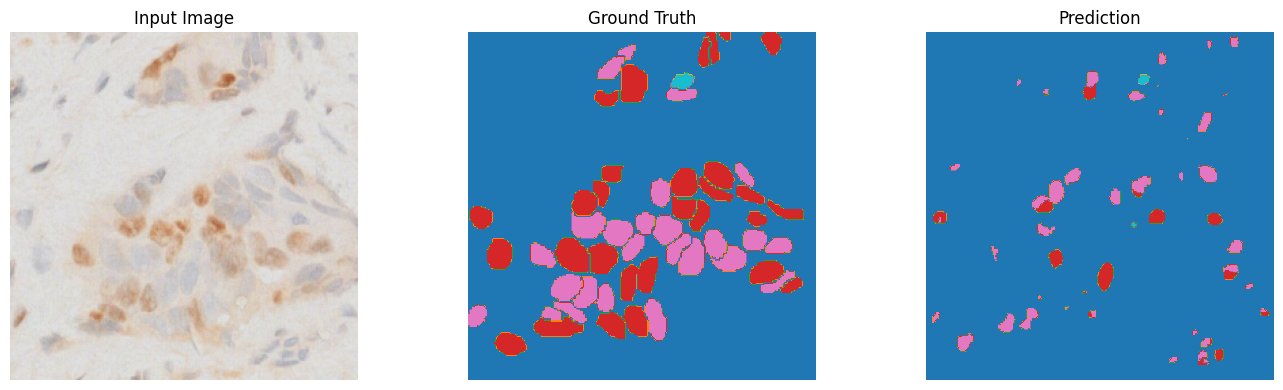

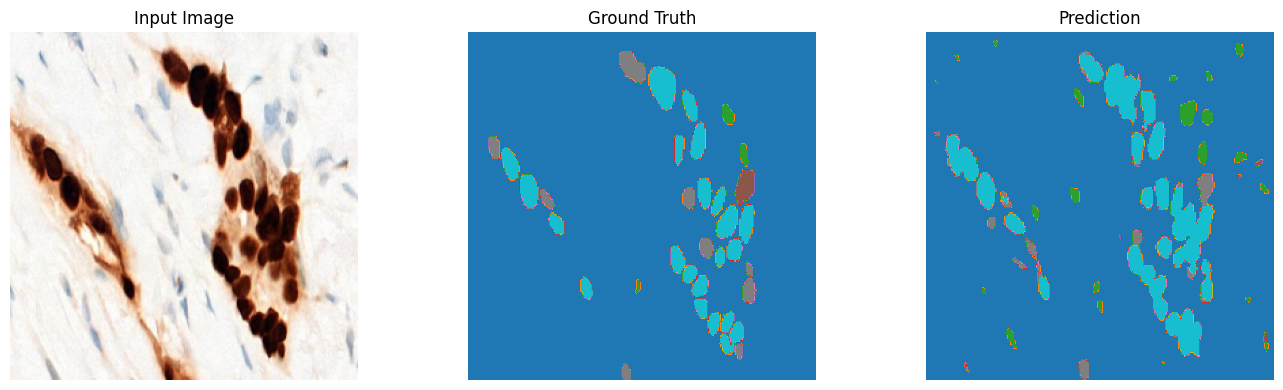

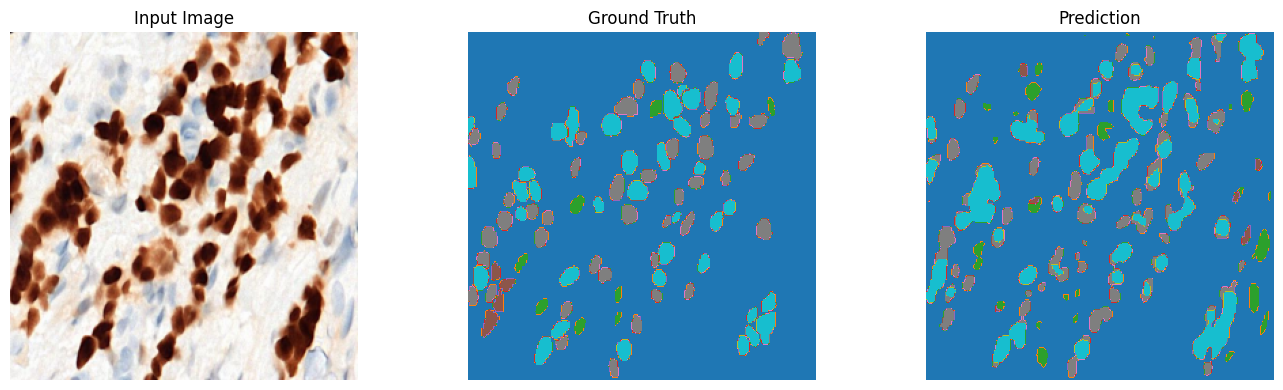

In [20]:
def denormalize(tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1).to(tensor.device)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1).to(tensor.device)
    return tensor * std + mean

def visualize_predictions(model, dataloader, num_samples=3):
    model.eval()
    device = next(model.parameters()).device

    with torch.no_grad():
        for images, masks in dataloader:
            images = images.to(device)
            preds = model(images)
            preds = torch.argmax(preds, dim=1).cpu().numpy()
            masks = masks.numpy()
            images = images.cpu()

            for i in range(num_samples):
                img = denormalize(images[i]).permute(1, 2, 0).numpy()
                fig, axs = plt.subplots(1, 3, figsize=(14, 4))
                axs[0].imshow(img)
                axs[0].set_title("Input Image")
                axs[1].imshow(masks[i], cmap="tab10")
                axs[1].set_title("Ground Truth")
                axs[2].imshow(preds[i], cmap="tab10")
                axs[2].set_title("Prediction")
                for ax in axs:
                    ax.axis("off")
                plt.tight_layout()
                plt.show()
            break
visualize_predictions(model_a, train_loader, num_samples=3)


Classification Report:
              precision    recall  f1-score   support

           0      0.929     0.961     0.945  11018785
           1      0.864     0.730     0.792   2551535
           2      0.408     0.327     0.363    221648
           3      0.636     0.394     0.487    374204
           4      0.507     0.892     0.646    251748

    accuracy                          0.895  14417920
   macro avg      0.669     0.661     0.646  14417920
weighted avg      0.894     0.895     0.892  14417920



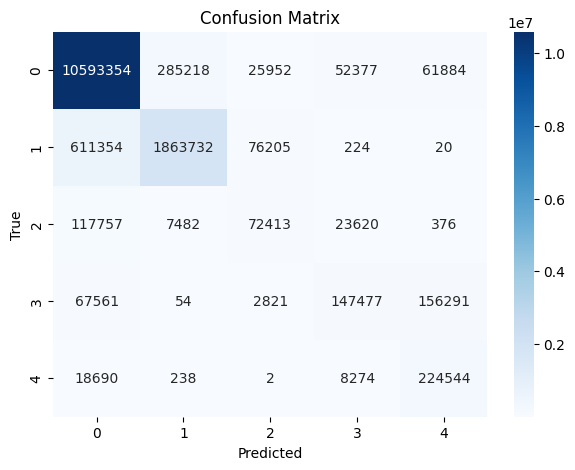

In [17]:
evaluate_model(model_a, train_loader)


Pixel-Level Metrics:

F1 Score per Class:
[0.94538578 0.79933169 0.35938308 0.480374   0.64250603]

IoU per Class:
[0.89642806 0.66573897 0.21905362 0.31611331 0.47330304]

Dice Score per Class:
[0.9454 0.7993 0.3594 0.4804 0.6425]


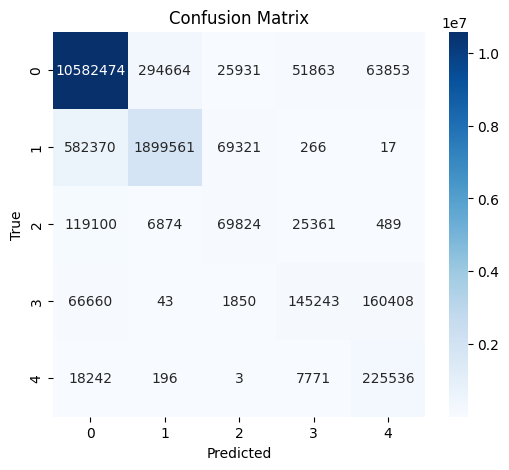

In [22]:
from sklearn.metrics import f1_score, confusion_matrix, precision_score, recall_score, jaccard_score
from scipy.ndimage import label
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns

def compute_pixel_metrics(model, dataloader, num_classes=5):
    device = next(model.parameters()).device
    model.eval()
    
    all_preds, all_gts = [], []

    with torch.no_grad():
        for images, masks in dataloader:
            images = images.to(device)
            masks = masks.cpu().numpy().flatten()
            preds = model(images)
            preds = torch.argmax(preds, dim=1).cpu().numpy().flatten()

            all_preds.extend(preds)
            all_gts.extend(masks)

    print("Pixel-Level Metrics:\n")
    print("F1 Score per Class:")
    print(f1_score(all_gts, all_preds, average=None, labels=list(range(num_classes))))
    
    print("\nIoU per Class:")
    print(jaccard_score(all_gts, all_preds, average=None, labels=list(range(num_classes))))

    print("\nDice Score per Class:")
    dice = []
    for c in range(num_classes):
        pred_c = np.array(all_preds) == c
        gt_c = np.array(all_gts) == c
        intersection = np.logical_and(pred_c, gt_c).sum()
        dice_score = (2. * intersection) / (pred_c.sum() + gt_c.sum() + 1e-6)
        dice.append(dice_score)
    print(np.round(dice, 4))

    # Optional: Confusion matrix
    cm = confusion_matrix(all_gts, all_preds, labels=list(range(num_classes)))
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()
compute_pixel_metrics(model_a, train_loader, num_classes=5)

# SegFormer-B2

In [44]:
!pip install -q segmentation-models-pytorch transformers timm


In [48]:
import torch.nn.functional as F

class SegFormerB(nn.Module):
    def __init__(self, num_classes=5):
        super().__init__()
        self.model = SegformerForSemanticSegmentation.from_pretrained(
            "nvidia/segformer-b2-finetuned-ade-512-512",
            num_labels=num_classes,
            ignore_mismatched_sizes=True
        )

    def forward(self, x):
        out = self.model(pixel_values=x).logits
        # Upsample to match ground truth resolution
        out = F.interpolate(out, size=(x.shape[2], x.shape[3]), mode='bilinear', align_corners=False)
        return out


In [49]:
def get_transforms():
    return A.Compose([
        A.Resize(512, 512),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.2),
        A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),  # recommended for SegFormer
        ToTensorV2()
    ])


In [50]:
model_b = SegFormerB(num_classes=5)
model_b = train_model(model_b, train_loader, epochs=15)  # You may need 15–20 epochs


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b2-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.weight: found shape torch.Size([150, 768, 1, 1]) in the checkpoint and torch.Size([5, 768, 1, 1]) in the model instantiated
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([5]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/15, Loss: 0.6525
Epoch 2/15, Loss: 0.4463
Epoch 3/15, Loss: 0.3979
Epoch 4/15, Loss: 0.4067
Epoch 5/15, Loss: 0.3739
Epoch 6/15, Loss: 0.3630
Epoch 7/15, Loss: 0.3503
Epoch 8/15, Loss: 0.3584
Epoch 9/15, Loss: 0.3313
Epoch 10/15, Loss: 0.3290
Epoch 11/15, Loss: 0.3156
Epoch 12/15, Loss: 0.3003
Epoch 13/15, Loss: 0.3258
Epoch 14/15, Loss: 0.3258
Epoch 15/15, Loss: 0.2996


In [73]:
def denormalize(tensor):
    img = tensor.clone().detach().cpu()
    img = img.permute(1, 2, 0).numpy()  # (H, W, C)
    img = (img * 0.5) + 0.5  # Undo Normalize(mean=0.5, std=0.5)
    return np.clip(img, 0, 1)


In [74]:
def visualize_predictions(model, dataloader, num_samples=3):
    model.eval()
    device = next(model.parameters()).device

    with torch.no_grad():
        for images, masks in dataloader:
            images = images.to(device)
            preds = model(images)
            preds = torch.argmax(preds, dim=1).cpu().numpy()
            masks = masks.numpy()

            for i in range(num_samples):
                img = denormalize(images[i])

                fig, axs = plt.subplots(1, 3, figsize=(14, 4))
                axs[0].imshow(img)
                axs[0].set_title("Input Image")
                axs[1].imshow(masks[i], cmap="tab10")
                axs[1].set_title("Ground Truth")
                axs[2].imshow(preds[i], cmap="tab10")
                axs[2].set_title("Prediction")
                for ax in axs:
                    ax.axis("off")
                plt.tight_layout()
                plt.show()
            break


In [75]:
from sklearn.metrics import f1_score, jaccard_score, confusion_matrix
import seaborn as sns

def compute_pixel_metrics(model, dataloader, num_classes=5):
    device = next(model.parameters()).device
    model.eval()
    all_preds, all_gts = [], []

    with torch.no_grad():
        for images, masks in dataloader:
            images = images.to(device)
            preds = model(images)
            preds = torch.argmax(preds, dim=1).cpu().numpy().flatten()
            masks = masks.numpy().flatten()
            all_preds.extend(preds)
            all_gts.extend(masks)

    print("Pixel-Level Metrics:\n")
    print("F1 Score per Class:")
    print(f1_score(all_gts, all_preds, average=None, labels=list(range(num_classes))))
    
    print("\nIoU per Class:")
    print(jaccard_score(all_gts, all_preds, average=None, labels=list(range(num_classes))))

    print("\nDice Score per Class:")
    dice = []
    for c in range(num_classes):
        pred_c = np.array(all_preds) == c
        gt_c = np.array(all_gts) == c
        intersection = np.logical_and(pred_c, gt_c).sum()
        dice_score = (2. * intersection) / (pred_c.sum() + gt_c.sum() + 1e-6)
        dice.append(dice_score)
    print(np.round(dice, 4))

    # Confusion matrix
    cm = confusion_matrix(all_gts, all_preds, labels=list(range(num_classes)))
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()


In [76]:
from scipy.ndimage import label

def compute_instance_metrics(pred_mask, gt_mask, num_classes=5):
    matched = 0
    total_gt = 0
    total_pred = 0
    iou_scores = []

    for cls in range(1, num_classes):  # Skip background
        gt_binary = (gt_mask == cls).astype(np.uint8)
        pred_binary = (pred_mask == cls).astype(np.uint8)

        labeled_gt, n_gt = label(gt_binary)
        labeled_pred, n_pred = label(pred_binary)

        total_gt += n_gt
        total_pred += n_pred

        for gt_id in range(1, n_gt + 1):
            gt_obj = (labeled_gt == gt_id).astype(np.uint8)
            best_iou = 0
            for pred_id in range(1, n_pred + 1):
                pred_obj = (labeled_pred == pred_id).astype(np.uint8)
                intersection = np.logical_and(gt_obj, pred_obj).sum()
                union = np.logical_or(gt_obj, pred_obj).sum()
                iou = intersection / (union + 1e-6)
                best_iou = max(best_iou, iou)
            if best_iou > 0.5:
                matched += 1
                iou_scores.append(best_iou)

    accuracy = matched / (total_gt + 1e-6)
    mean_instance_iou = np.mean(iou_scores) if iou_scores else 0
    print("\nInstance-Level Metrics:")
    print(f"Matched Nuclei: {matched}")
    print(f"Total Ground Truth: {total_gt}")
    print(f"Total Predicted: {total_pred}")
    print(f"Instance Classification Accuracy: {accuracy:.4f}")
    print(f"Mean Nucleus IoU: {mean_instance_iou:.4f}")


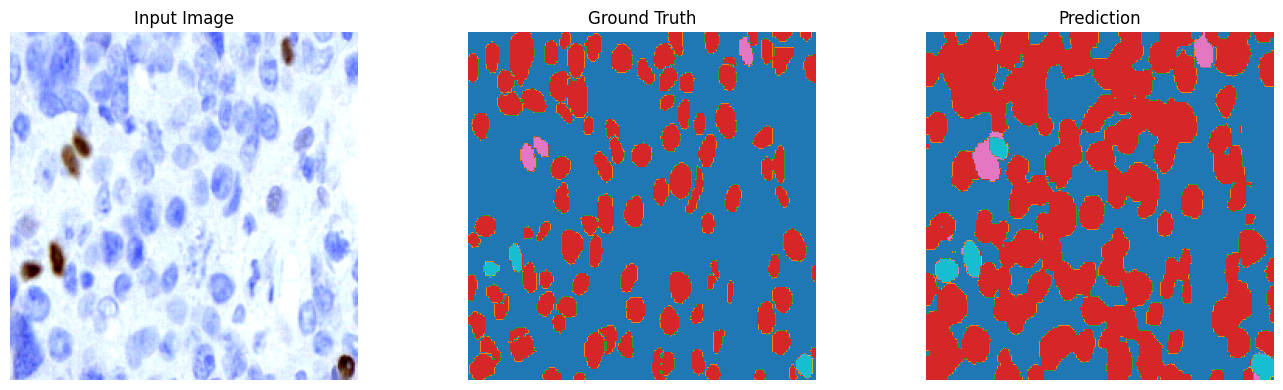

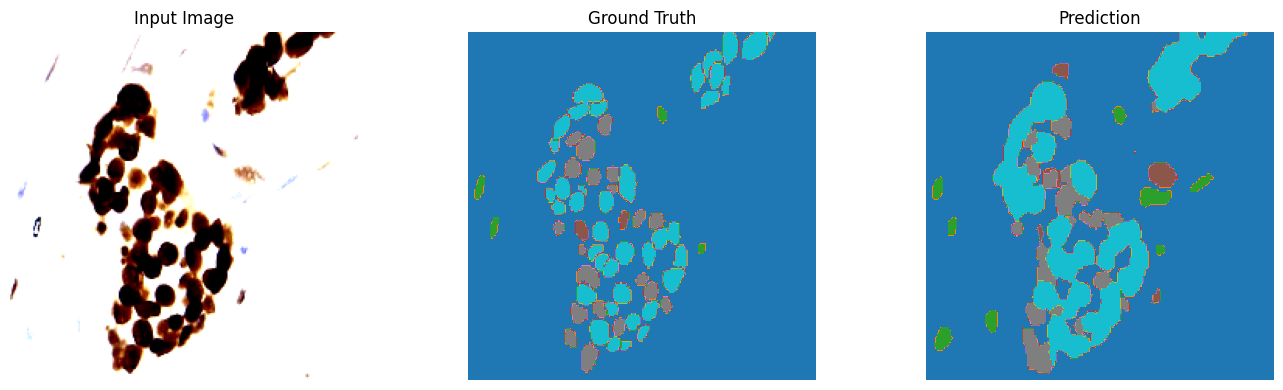

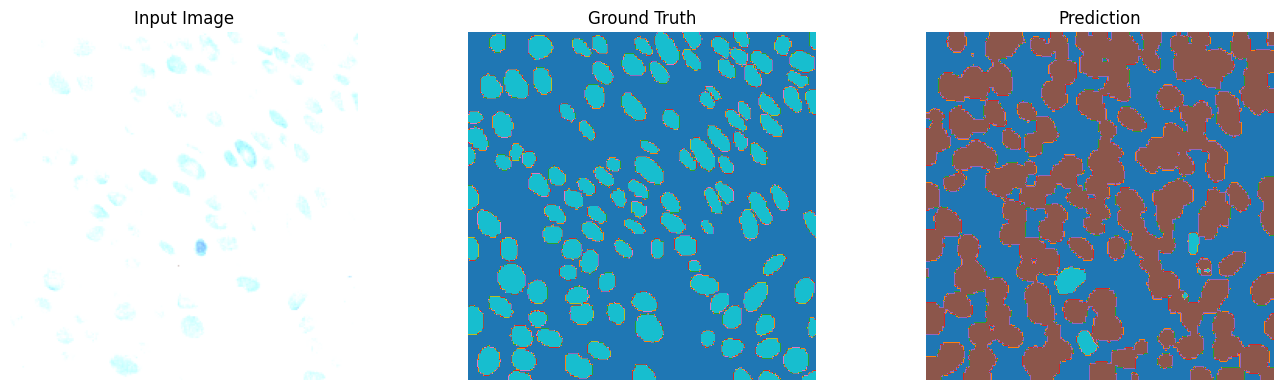

Pixel-Level Metrics:

F1 Score per Class:
[0.85197602 0.69464821 0.40069118 0.60241771 0.66215389]

IoU per Class:
[0.74212389 0.53215402 0.25054022 0.43104274 0.49494025]

Dice Score per Class:
[0.852  0.6946 0.4007 0.6024 0.6622]


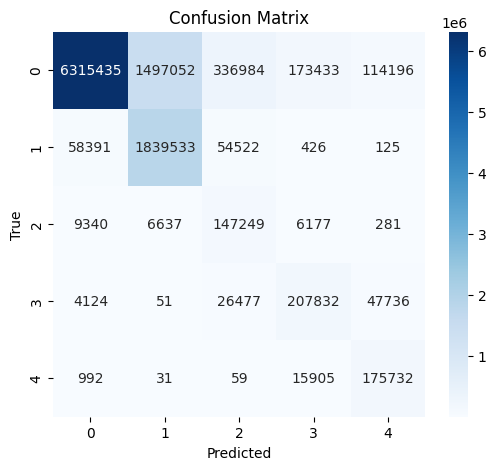


Instance-Level Metrics:
Matched Nuclei: 36
Total Ground Truth: 71
Total Predicted: 77
Instance Classification Accuracy: 0.5070
Mean Nucleus IoU: 0.6989


In [77]:
# Visualize predictions
visualize_predictions(model_b, train_loader)

# Pixel-level metrics
compute_pixel_metrics(model_b, train_loader)

# Instance-level on one sample
for images, masks in train_loader:
    images = images.to(next(model_b.parameters()).device)
    preds = model_b(images)
    pred_mask = torch.argmax(preds, dim=1).cpu().numpy()[0]
    compute_instance_metrics(pred_mask, masks[0].numpy())
    break


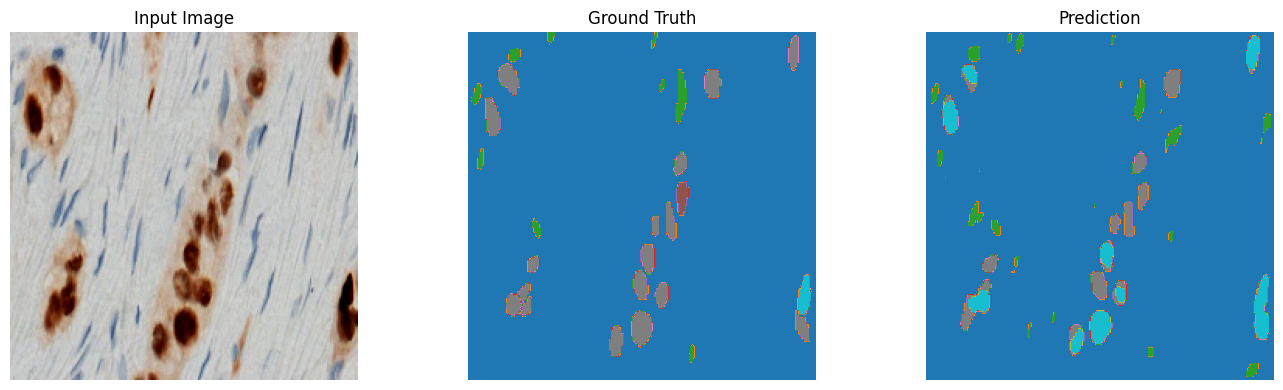

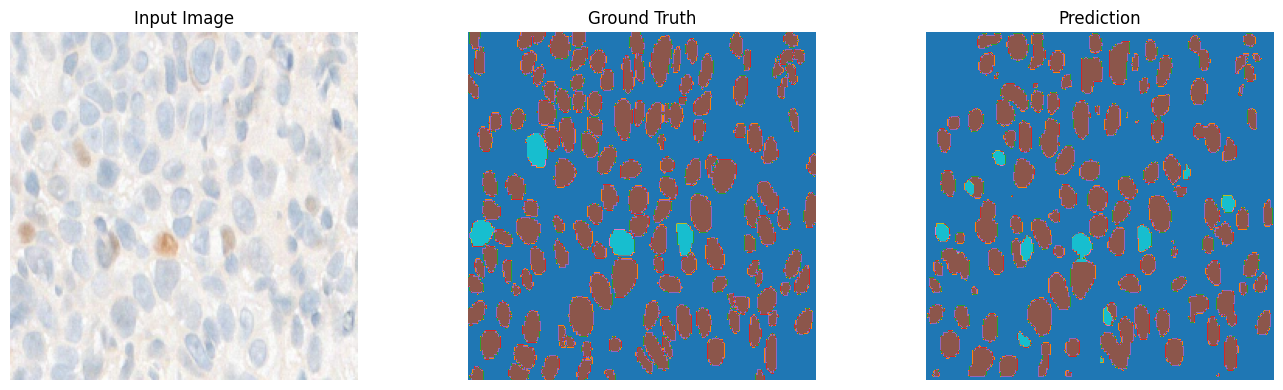

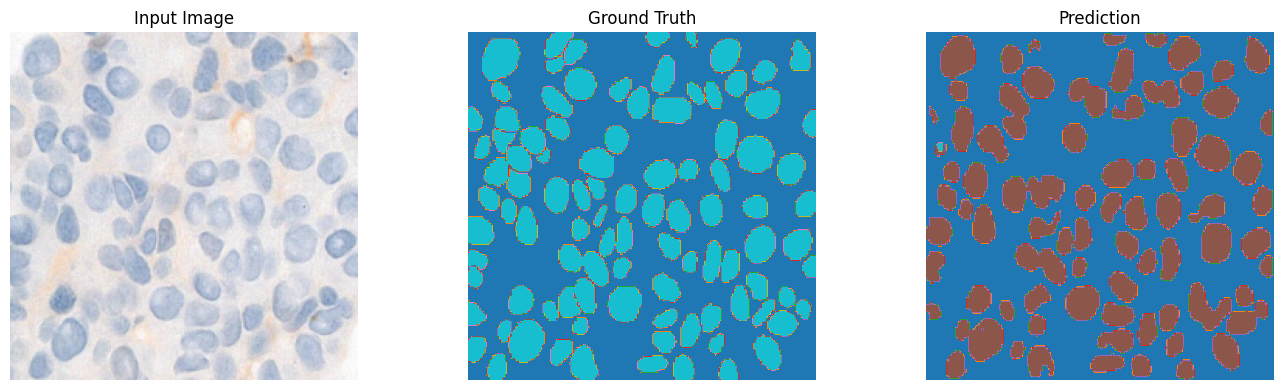

In [78]:
def denormalize(tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1).to(tensor.device)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1).to(tensor.device)
    return tensor * std + mean

def visualize_predictions(model, dataloader, num_samples=3):
    model.eval()
    device = next(model.parameters()).device

    with torch.no_grad():
        for images, masks in dataloader:
            images = images.to(device)
            preds = model(images)
            preds = torch.argmax(preds, dim=1).cpu().numpy()
            masks = masks.numpy()
            images = images.cpu()

            for i in range(num_samples):
                img = denormalize(images[i]).permute(1, 2, 0).numpy()
                fig, axs = plt.subplots(1, 3, figsize=(14, 4))
                axs[0].imshow(img)
                axs[0].set_title("Input Image")
                axs[1].imshow(masks[i], cmap="tab10")
                axs[1].set_title("Ground Truth")
                axs[2].imshow(preds[i], cmap="tab10")
                axs[2].set_title("Prediction")
                for ax in axs:
                    ax.axis("off")
                plt.tight_layout()
                plt.show()
            break
visualize_predictions(model_a, train_loader, num_samples=3)


Pixel-Level Metrics:

F1 Score per Class:
[0.93997534 0.77851516 0.35796786 0.50019587 0.64207188]

IoU per Class:
[0.88674855 0.63735147 0.21800295 0.33350746 0.472832  ]

Dice Score per Class:
[0.94   0.7785 0.358  0.5002 0.6421]


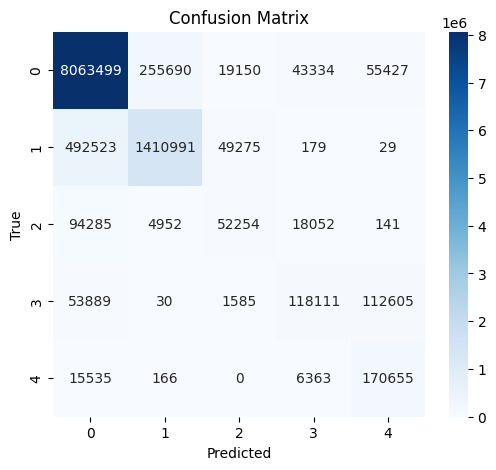

In [79]:
from sklearn.metrics import f1_score, confusion_matrix, precision_score, recall_score, jaccard_score
from scipy.ndimage import label
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns

def compute_pixel_metrics(model, dataloader, num_classes=5):
    device = next(model.parameters()).device
    model.eval()
    
    all_preds, all_gts = [], []

    with torch.no_grad():
        for images, masks in dataloader:
            images = images.to(device)
            masks = masks.cpu().numpy().flatten()
            preds = model(images)
            preds = torch.argmax(preds, dim=1).cpu().numpy().flatten()

            all_preds.extend(preds)
            all_gts.extend(masks)

    print("Pixel-Level Metrics:\n")
    print("F1 Score per Class:")
    print(f1_score(all_gts, all_preds, average=None, labels=list(range(num_classes))))
    
    print("\nIoU per Class:")
    print(jaccard_score(all_gts, all_preds, average=None, labels=list(range(num_classes))))

    print("\nDice Score per Class:")
    dice = []
    for c in range(num_classes):
        pred_c = np.array(all_preds) == c
        gt_c = np.array(all_gts) == c
        intersection = np.logical_and(pred_c, gt_c).sum()
        dice_score = (2. * intersection) / (pred_c.sum() + gt_c.sum() + 1e-6)
        dice.append(dice_score)
    print(np.round(dice, 4))

    # Optional: Confusion matrix
    cm = confusion_matrix(all_gts, all_preds, labels=list(range(num_classes)))
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()
compute_pixel_metrics(model_a, train_loader, num_classes=5)

In [81]:
from sklearn.metrics import classification_report

def print_classification_report(model, dataloader, num_classes=5):
    device = next(model.parameters()).device
    model.eval()
    all_preds, all_gts = [], []

    with torch.no_grad():
        for images, masks in dataloader:
            images = images.to(device)
            preds = model(images)
            preds = torch.argmax(preds, dim=1).cpu().numpy().flatten()
            masks = masks.numpy().flatten()
            all_preds.extend(preds)
            all_gts.extend(masks)

    print("🔍 Classification Report (Pixel-wise):\n")
    target_names = ['Background', 'Normal', 'Weak', 'Moderate', 'Strong']
    print(classification_report(all_gts, all_preds, labels=list(range(num_classes)), target_names=target_names, digits=4))
print_classification_report(model_b, train_loader)


🔍 Classification Report (Pixel-wise):

              precision    recall  f1-score   support

  Background     0.9936    0.7450    0.8515   8437100
      Normal     0.5511    0.9560    0.6991   1952997
        Weak     0.2628    0.8855    0.4053    169684
    Moderate     0.5105    0.6981    0.5898    286220
      Strong     0.4918    0.9233    0.6418    192719

    accuracy                         0.7864  11038720
   macro avg     0.5620    0.8416    0.6375  11038720
weighted avg     0.8828    0.7864    0.8073  11038720



# Define the Hybrid Model "fusion network"


In [82]:
class HybridFusionModel(nn.Module):
    def __init__(self, model_a, model_b, num_classes=5):
        super(HybridFusionModel, self).__init__()
        self.model_a = model_a
        self.model_b = model_b
        self.fusion = nn.Sequential(
            nn.Conv2d(2 * num_classes, 64, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, num_classes, kernel_size=1)
        )

    def forward(self, x):
        logits_a = self.model_a(x)
        logits_b = self.model_b(x)
        fused_input = torch.cat([logits_a, logits_b], dim=1)  # along channel axis
        out = self.fusion(fused_input)
        return out


In [83]:
def freeze(model):
    for param in model.parameters():
        param.requires_grad = False

freeze(model_a)
freeze(model_b)


In [84]:
hybrid_model = HybridFusionModel(model_a, model_b, num_classes=5)
hybrid_model = train_model(hybrid_model, train_loader, epochs=10)


Epoch 1/10, Loss: 0.7627
Epoch 2/10, Loss: 0.3804
Epoch 3/10, Loss: 0.3269
Epoch 4/10, Loss: 0.3269
Epoch 5/10, Loss: 0.3268
Epoch 6/10, Loss: 0.3279
Epoch 7/10, Loss: 0.3028
Epoch 8/10, Loss: 0.3104
Epoch 9/10, Loss: 0.3061
Epoch 10/10, Loss: 0.3006


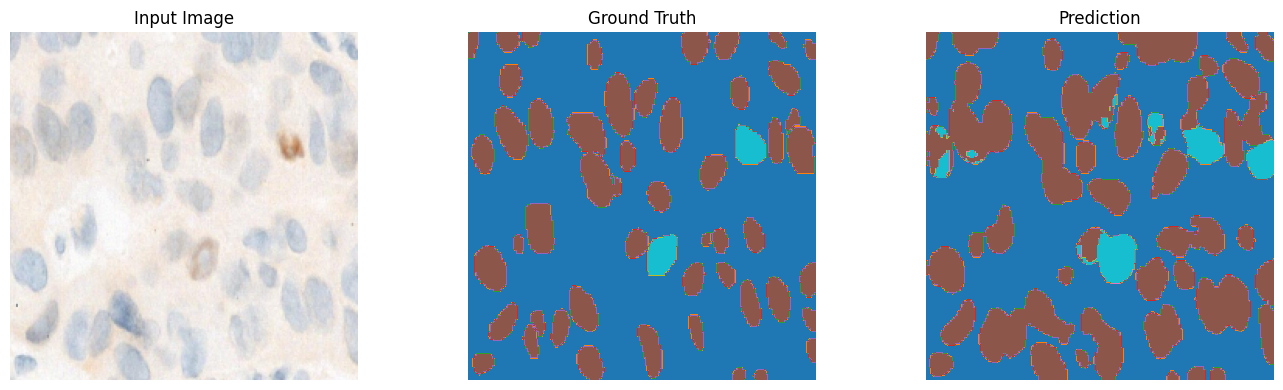

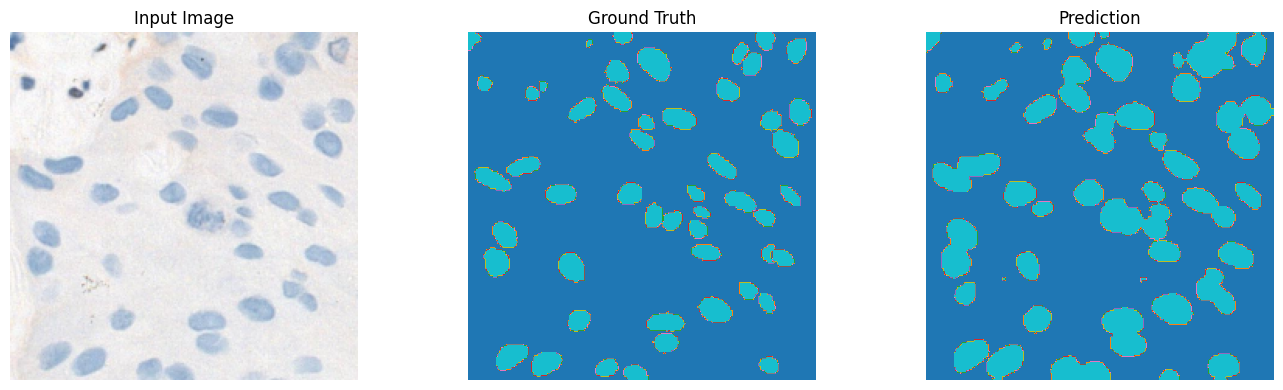

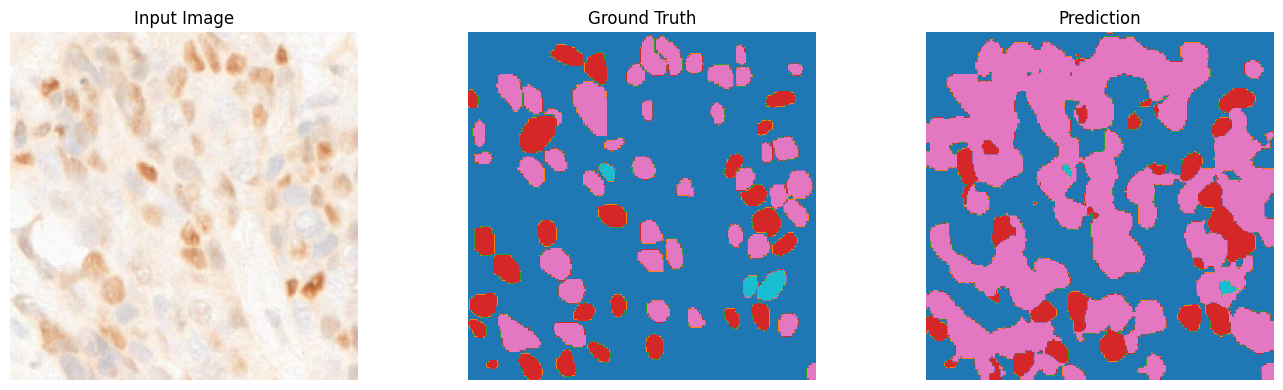

Pixel-Level Metrics:

F1 Score per Class:
[0.85398365 0.7059238  0.44513159 0.57101922 0.68081136]

IoU per Class:
[0.7451758  0.54550404 0.28628249 0.39959895 0.5160834 ]

Dice Score per Class:
[0.854  0.7059 0.4451 0.571  0.6808]


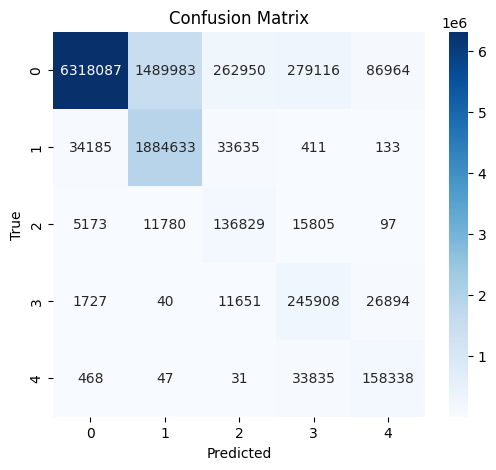

🔍 Classification Report (Pixel-wise):

              precision    recall  f1-score   support

  Background     0.9905    0.7497    0.8535   8437100
      Normal     0.5556    0.9557    0.7027   1952997
        Weak     0.3096    0.8137    0.4485    169684
    Moderate     0.4328    0.8516    0.5739    286220
      Strong     0.5704    0.8398    0.6794    192719

    accuracy                         0.7914  11038720
   macro avg     0.5718    0.8421    0.6516  11038720
weighted avg     0.8813    0.7914    0.8103  11038720


Instance-Level Metrics:
Matched Nuclei: 8
Total Ground Truth: 44
Total Predicted: 84
Instance Classification Accuracy: 0.1818
Mean Nucleus IoU: 0.6300


In [85]:
visualize_predictions(hybrid_model, train_loader)
compute_pixel_metrics(hybrid_model, train_loader)
print_classification_report(hybrid_model, train_loader)

# Optional: instance-level
for images, masks in train_loader:
    images = images.to(next(hybrid_model.parameters()).device)
    preds = torch.argmax(hybrid_model(images), dim=1).cpu().numpy()[0]
    compute_instance_metrics(preds, masks[0].numpy())
    break
